In [1]:
import numpy as np
#This following is so that this will work with Latex, see
#http://bkanuka.com/articles/native-latex-plots/
import matplotlib as mpl
mpl.use('pgf')

In [2]:
def figsize(scale):                                 # I think scale is the size you want it on the page
    fig_width_pt = 433.62001                        # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.0                        # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_lualatex = {                      # Setup matplotlib to use latex for output
    "pgf.texsystem": "lualatex",           # Change this if using xetex or luatex
    "text.usetex": True,                   # Use LaTeX to write all text
    "pgf.rcfonts": False,
    #Fonts
    "font.family": "serif",                # Get from the pdf font function on the doc
    "font.serif": "Computer Modern Roman",      
    #"font.sans-serif": "Computer Modern Sans serif",
    #"font.serif": [],      
    "font.sans-serif": [],
    "font.monospace": [], # Blank entries should cause plots to inherit fonts from the document
    #Text size
    "font.size": 11,# Document default is 11pt font.
    #"text.fontsize": 11,
    "axes.labelsize": 11,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    ##Axis
    #"axes.labelpad": 2,     # space between label and axis 
    "figure.figsize": figsize(1.0),     # default fig size of 1.0 textwidth
    #Packages
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        r"\usepackage{amsmath}",  #need to add math or the ^ won't work
        r"\usepackage{amssymb}"]
    }

mpl.rcParams.update(pgf_with_lualatex)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from scipy.integrate import quad
from scipy.special import gamma
from scipy.optimize import curve_fit
from scipy.odr import ODR, Model, Data, RealData

In [5]:
%matplotlib inline
plt.style.use('seaborn-ticks')
sns.set_palette("muted")

In [6]:
# Header for loading data
col_names = ['slug', 'wien', 'md_asym', 'md_asym_err', 'lumi_asym', 'lumi_asym_err', 'precession', 'wien_state', 'ihwp', 'sc']

In [7]:
df = pd.read_csv('data/al_md_uslumi_asymmetries.csv', header=None, names=col_names)

In [8]:
df.head()

,slug,wien,md_asym,md_asym_err,lumi_asym,lumi_asym_err,precession,wien_state,ihwp,sc
0,1028,6,-1.476105,0.295932,-10.29040,0.295932,reverse,normal,out,-1
1,1029,6,1.818873,0.370497,-9.56512,0.370497,reverse,normal,in,1
2,1030,6,-1.623430,0.333129,-9.18098,0.333129,reverse,normal,out,-1
3,1031,6,1.635866,0.337508,-7.38128,0.337508,reverse,normal,in,1
4,1032,6,-0.912987,0.524059,-6.23302,0.524059,reverse,normal,out,-1


In [9]:
def calc_chi2(fit, data, err, dof):
    chi2 = np.sum(np.square(data-fit)/np.square(err))
    return chi2, chi2/dof

def chi2probdistribution(chi2, dof):
    if chi2 > 0:
        num = np.power(chi2,(dof-2.0)/2.0)*np.exp(-chi2/2.0)
        dem = np.power(2.0,(dof/2.0))*gamma(dof/2.0)
        return num/dem
    elif chi2 == 0:
        return 0
    else:
        print('Chi^2 values < 0 not valid!')
        
def calc_chi2prob(chi2, dof):
    return quad(chi2probdistribution, chi2, np.inf, (dof))

In [10]:
def flinear(x, m, b):
    return m*x + b

In [11]:
def line(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

In [12]:
linear = Model(line)

In [13]:
data = RealData(df.sc*df.lumi_asym, df.sc*df.md_asym, sx=df.lumi_asym_err, sy=df.md_asym_err)

In [14]:
odr = ODR(data, linear, beta0=[0.5, 1.4])
odr.set_job(fit_type=0)

In [15]:
output = odr.run()

In [16]:
output.pprint()

Beta: [0.00658051 1.43670857]
Beta Std Error: [0.00699525 0.08037616]
Beta Covariance: [[ 3.49021706e-05 -2.46911193e-05]
 [-2.46911193e-05  4.60787913e-03]]
Residual Variance: 1.402017596667818
Inverse Condition #: 0.09317317255169232
Reason(s) for Halting:
  Sum of squares convergence


In [17]:
popt, pcov = curve_fit(flinear, df.sc*df.lumi_asym, df.sc*df.md_asym, sigma=df.md_asym_err)

In [18]:
popt, np.sqrt(np.diag(pcov))

(array([0.00657182, 1.43671472]), array([0.00699524, 0.08037616]))

In [19]:
chi2, rchi2 = calc_chi2(line(output.beta, df.lumi_asym), df.md_asym, df.md_asym_err, 27)
calc_chi2prob(chi2, 27)

(6.627949530062278e-192, 7.86358309827593e-193)

In [20]:
x = np.linspace(-30.0, 30.0, 100)

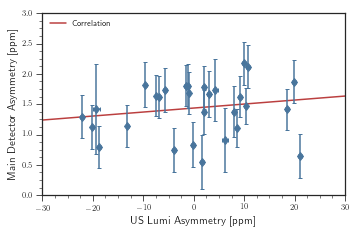

In [90]:
fig, ax = plt.subplots(figsize=figsize(0.9))
plt.errorbar(df.sc*df.lumi_asym,
             df.sc*df.md_asym,
             xerr=df.lumi_asym_err,
             yerr=df.md_asym_err,
             ls='None',
             marker='d',
             capsize=2.0,
             capthick=1.0,
             barsabove=True,
             color=sns.xkcd_rgb['dull blue'])
plt.plot(x, 
         line(output.beta, x), 
         ls='-', 
         color=sns.xkcd_rgb['dull red'],
         label='Correlation', zorder=-1)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_xlim(-30, 30)
ax.set_ylim(0.0, 3.0)
ax.set_xlabel('US Lumi Asymmetry [ppm]')
ax.set_ylabel('Main Detector Asymmetry [ppm]')
ax.legend(loc='upper left')
plt.savefig('plots/al_md_lumi_correlation.pdf', bbox_inches='tight')
plt.savefig('plots/al_md_lumi_correlation.png', bbox_inches='tight')
plt.savefig('plots/al_md_lumi_correlation.pgf', bbox_inches='tight')
plt.show()